<a href="https://colab.research.google.com/github/baileysmoko/Fabric/blob/main/FRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = "b9d792ee-8769-44d9-ab43-109cd8973c29"
headers = {"X-CMC_PRO_API_KEY": API_KEY}

def fetch_ohlcv(coin_id, symbol, days=730):
    """
    Fetch OHLCV data for a coin from CoinMarketCap.
    coin_id: int (CMC ID for the coin)
    symbol: str (e.g. 'BTC')
    days: int (how many days back to request)
    """
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/ohlcv/historical"
    time_end = datetime.utcnow()
    time_start = time_end - timedelta(days=days)

    params = {
        "id": coin_id,
        "time_start": time_start.strftime("%Y-%m-%d"),
        "time_end": time_end.strftime("%Y-%m-%d"),
        "convert": "USD"
    }

    r = requests.get(url, headers=headers, params=params)
    data = r.json()

    if "data" not in data or "quotes" not in data["data"]:
        raise ValueError(f"Error fetching {symbol}: {data}")

    # Normalize into dataframe
    records = []
    for entry in data["data"]["quotes"]:
        records.append({
            "time_open": entry["time_open"],
            "time_close": entry["time_close"],
            "time_high": entry["quote"]["USD"]["high"],
            "time_low": entry["quote"]["USD"]["low"],
            "time_open_price": entry["quote"]["USD"]["open"],
            "time_close_price": entry["quote"]["USD"]["close"],
            "volume": entry["quote"]["USD"]["volume"],
            "market_cap": entry["quote"]["USD"]["market_cap"]
        })

    df = pd.DataFrame(records)
    df.to_csv(f"{symbol}_2years.csv", index=False)
    return df

# BTC (id=1), ETH (id=1027)
btc_df = fetch_ohlcv(1, "BTC", days=730)
eth_df = fetch_ohlcv(1027, "ETH", days=730)

print("BTC dataset:", btc_df.shape)
print("ETH dataset:", eth_df.shape)


/tmp/ipython-input-4031693031.py:16: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  time_end = datetime.utcnow()


BTC dataset: (729, 8)
ETH dataset: (729, 8)


In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time

# -------------------------------
# CONFIG
# -------------------------------
API_KEY = "b9d792ee-8769-44d9-ab43-109cd8973c29"  # Replace with your CoinMarketCap API key
HEADERS = {"X-CMC_PRO_API_KEY": API_KEY, "Accept": "application/json"}

LIMIT = 100        # Top N coins per day
DAYS_BACK = 30     # How many days in the past to check

# -------------------------------
# 1. Collect all top 100 coin IDs for the past month
# -------------------------------
unique_coins = {}  # coin_id -> {'name': name, 'symbol': symbol}

today = datetime.now(timezone.utc)
for delta in range(DAYS_BACK):
    date = today - timedelta(days=delta)
    date_str = date.strftime("%Y-%m-%d")

    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/historical"
    params = {"date": date_str, "limit": LIMIT, "convert": "USD"}

    response = requests.get(url, headers=HEADERS, params=params)
    data = response.json()

    if "data" not in data:
        print(f"No data for {date_str}: {data}")
        continue

    for coin in data["data"]:
        coin_id = coin["id"]
        if coin_id not in unique_coins:
            unique_coins[coin_id] = {"name": coin["name"], "symbol": coin["symbol"]}

    time.sleep(1)  # rate-limit friendly

print(f"Found {len(unique_coins)} unique coins in top {LIMIT} over the past {DAYS_BACK} days.")

# -------------------------------
# 2. Get contract addresses for each unique coin
# -------------------------------
coins_list = []
for coin_id, info in unique_coins.items():
    url_info = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    params = {"id": coin_id}
    response = requests.get(url_info, headers=HEADERS, params=params)
    data = response.json()

    if "data" in data and str(coin_id) in data["data"]:
        platform = data["data"][str(coin_id)].get("platform")
        contract_address = platform.get("token_address") if platform else None
    else:
        contract_address = None

    coins_list.append({
        "name": info["name"],
        "symbol": info["symbol"],
        "contract_address": contract_address
    })

    time.sleep(0.5)  # rate-limit friendly

# -------------------------------
# 3. Create DataFrame
# -------------------------------
df = pd.DataFrame(coins_list)
print(df.head())
print(f"Total coins in final dataset: {len(df)}")


No data for 2025-09-24: {'status': {'timestamp': '2025-09-24T01:52:37.704Z', 'error_code': 400, 'error_message': 'Search query is out of range. Please select dates between 2010-07-13 and 2025-09-23, cacheFirstTime is info.first_historical_data 2010-07-13T00:05:00.000Z , query date is Wed Sep 24 2025 00:00:00 GMT+0000', 'elapsed': 0, 'credit_count': 0, 'notice': None}}
No data for 2025-09-17: {'status': {'timestamp': '2025-09-24T01:52:44.968Z', 'error_code': 400, 'error_message': 'Search query is out of range. Please select dates between 2025-09-24 and 2025-09-23, cacheFirstTime is info.first_historical_data undefined , query date is Wed Sep 17 2025 00:00:00 GMT+0000', 'elapsed': 0, 'credit_count': 0, 'notice': None}}
Found 112 unique coins in top 100 over the past 30 days.
          name symbol                            contract_address
0      Bitcoin    BTC                                        None
1     Ethereum    ETH                                        None
2  Tether USDt   U

In [ ]:
from google.colab import files
files.download("/content/top100_last_month_contracts.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load BTC dataset ---
btc = pd.read_csv("BTC_2years.csv", parse_dates=["time_open"])
btc = btc.sort_values("time_open").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["time_close_price"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["time_close_price"].ewm(span=ema_long, adjust=False).mean()

# ATR14 calculation
btc["high_low"] = btc["time_high"] - btc["time_low"]
btc["high_close"] = np.abs(btc["time_high"] - btc["time_close_price"].shift())
btc["low_close"] = np.abs(btc["time_low"] - btc["time_close_price"].shift())
btc["TR"] = btc[["high_low", "high_close", "low_close"]].max(axis=1)
btc["ATR14"] = btc["TR"].rolling(atr_period).mean()

# --- Volume filter ---
btc["vol_ma20"] = btc["volume"].rolling(20).mean()

# --- Trading logic ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Entry condition: EMA20 crosses above EMA50 & volume > 20-day avg
    if not in_position and row["EMA20"] > row["EMA50"] and row["volume"] > row["vol_ma20"]:
        in_position = True
        entry_price = row["time_close_price"]
        stop_loss = entry_price - row["ATR14"]

    # Exit conditions
    elif in_position:
        if row["EMA20"] < row["EMA50"] or row["time_close_price"] <= stop_loss:
            exit_price = row["time_close_price"]
            pnl = (exit_price - entry_price) / entry_price * notional
            trades.append({
                "time_open": btc.iloc[i-1]["time_open"],
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": pnl
            })
            in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["time_open"], trades_df["cumulative_pnl"], label="EMA20/50 + ATR14 Strategy")
plt.title("BTC Momentum/Trend-Follow Strategy Backtest")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("Final PnL:", trades_df["cumulative_pnl"].iloc[-1] if len(trades_df) > 0 else 0)
print("Number of trades:", len(trades_df))
print("\nSample trades:")
print(trades_df.head(10))


Final PnL: 14587.690919900537
Number of trades: 9

Sample trades:
                  time_open   entry_price    exit_price           pnl  \
0 2023-10-10 00:00:00+00:00  27530.784890  26873.321121   -238.810398   
1 2024-04-30 00:00:00+00:00  26862.375446  58254.009853  11686.097706   
2 2024-05-22 00:00:00+00:00  71448.195191  67929.563039   -492.473203   
3 2024-06-13 00:00:00+00:00  68526.097774  66011.093727   -367.014047   
4 2024-06-20 00:00:00+00:00  66490.294175  64096.198188   -360.066987   
5 2024-07-30 00:00:00+00:00  67585.249972  64619.249649   -438.853200   
6 2024-08-01 00:00:00+00:00  65357.501563  61415.064573   -603.211092   
7 2024-09-30 00:00:00+00:00  63329.802387  60837.009701   -393.620790   
8 2025-02-16 00:00:00+00:00  60632.786274  95773.384187   5795.642931   

   cumulative_pnl  
0     -238.810398  
1    11447.287308  
2    10954.814105  
3    10587.800059  
4    10227.733072  
5     9788.879872  
6     9185.668780  
7     8792.047989  
8    14587.690920  


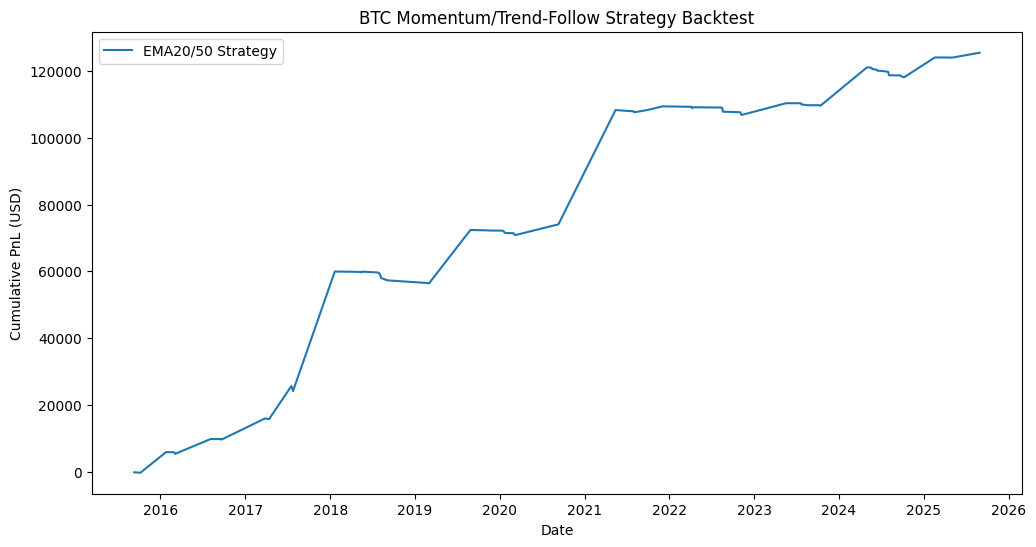

Final PnL: 125496.9144030333
Number of trades: 100

Sample trades:
         day  entry_price  exit_price          pnl  cumulative_pnl
0 2015-09-10       243.41      238.33  -208.701368     -208.701368
1 2015-10-07       246.17      243.07  -125.929236     -334.630604
2 2016-01-25       242.50      392.00  6164.948454     5830.317850
3 2016-02-23       421.60      420.96   -15.180266     5815.137584
4 2016-02-25       425.04      424.63    -9.646151     5805.491433
5 2016-02-27       432.84      432.57    -6.237871     5799.253562
6 2016-03-02       433.44      423.91  -219.868955     5579.384607
7 2016-03-04       421.84      410.78  -262.184715     5317.199892
8 2016-08-04       400.52      578.28  4438.230301     9755.430193
9 2016-09-15       608.02      607.25   -12.664057     9742.766136


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load BTC dataset ---
btc = pd.read_csv("New_Query (1).csv", parse_dates=["day"])
btc = btc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["close_usd"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# ATR14 calculation
btc["high_low"] = 0  # No high/low data, set to 0
btc["high_close"] = 0
btc["low_close"] = 0
btc["TR"] = btc[["high_low", "high_close", "low_close"]].max(axis=1)
btc["ATR14"] = btc["TR"].rolling(atr_period).mean()

# --- Trading logic (without volume filter) ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Entry condition: EMA20 crosses above EMA50
    if not in_position and row["EMA20"] > row["EMA50"]:
        in_position = True
        entry_price = row["close_usd"]
        stop_loss = entry_price - row["ATR14"]

    # Exit conditions
    elif in_position:
        if row["EMA20"] < row["EMA50"] or row["close_usd"] <= stop_loss:
            exit_price = row["close_usd"]
            pnl = (exit_price - entry_price) / entry_price * notional
            trades.append({
                "day": btc.iloc[i-1]["day"],
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": pnl
            })
            in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["day"], trades_df["cumulative_pnl"], label="EMA20/50 Strategy")
plt.title("BTC Momentum/Trend-Follow Strategy Backtest")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("Final PnL:", trades_df["cumulative_pnl"].iloc[-1] if len(trades_df) > 0 else 0)
print("Number of trades:", len(trades_df))
print("\nSample trades:")
print(trades_df.head(10))


In [ ]:
from google.colab import files

uploaded = files.upload()  # this will open a file picker


Saving New_Query (1).csv to New_Query (1).csv


Top parameter sets:
    ema_short  ema_long  atr_period     final_pnl  num_trades
9          10        80          21  16923.037305           6
8          10        80          14  16923.037305           6
32         25        50          14  16743.826445           8
33         25        50          21  16743.826445           8
1          10        40          21  16491.015392          10
0          10        40          14  16491.015392          10
30         25        40          14  16130.351910           8
31         25        40          21  16130.351910           8
25         20        60          21  16097.941946           6
24         20        60          14  16097.941946           6


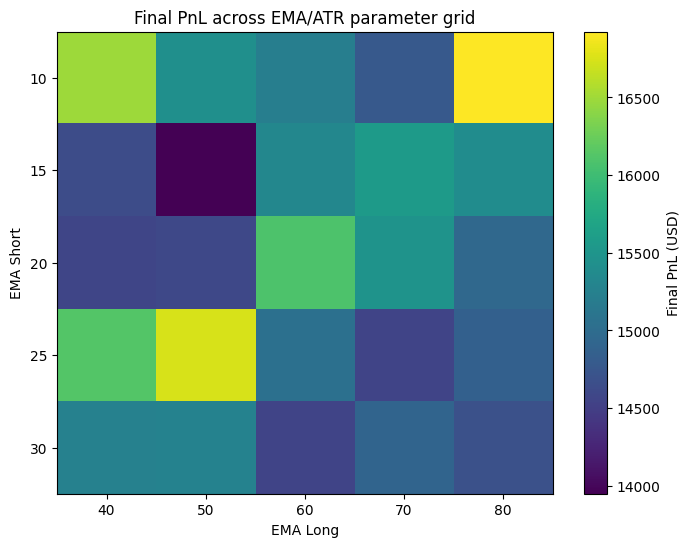

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# --- Load BTC dataset ---
btc = pd.read_csv("BTC_2years.csv", parse_dates=["time_open"])
btc = btc.sort_values("time_open").reset_index(drop=True)

# --- Function to run backtest ---
def run_backtest(ema_short, ema_long, atr_period, notional=10000):
    df = btc.copy()

    # Indicators
    df["EMA_short"] = df["time_close_price"].ewm(span=ema_short, adjust=False).mean()
    df["EMA_long"] = df["time_close_price"].ewm(span=ema_long, adjust=False).mean()

    # ATR calculation
    df["high_low"] = df["time_high"] - df["time_low"]
    df["high_close"] = np.abs(df["time_high"] - df["time_close_price"].shift())
    df["low_close"] = np.abs(df["time_low"] - df["time_close_price"].shift())
    df["TR"] = df[["high_low", "high_close", "low_close"]].max(axis=1)
    df["ATR"] = df["TR"].rolling(atr_period).mean()

    # Volume filter
    df["vol_ma20"] = df["volume"].rolling(20).mean()

    # Trading logic
    trades = []
    in_position = False
    entry_price = 0.0
    stop_loss = 0.0

    for i in range(1, len(df)):
        row = df.iloc[i]

        # Entry condition
        if not in_position and row["EMA_short"] > row["EMA_long"] and row["volume"] > row["vol_ma20"]:
            in_position = True
            entry_price = row["time_close_price"]
            stop_loss = entry_price - row["ATR"]

        # Exit condition
        elif in_position:
            if row["EMA_short"] < row["EMA_long"] or row["time_close_price"] <= stop_loss:
                exit_price = row["time_close_price"]
                pnl = (exit_price - entry_price) / entry_price * notional
                trades.append({
                    "entry_time": df.iloc[i-1]["time_open"],
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl
                })
                in_position = False

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
        final_pnl = trades_df["cumulative_pnl"].iloc[-1]
    else:
        final_pnl = 0

    return final_pnl, len(trades_df)


# --- Parameter grid ---
ema_short_vals = [10, 15, 20, 25, 30]
ema_long_vals = [40, 50, 60, 70, 80]
atr_period_vals = [14, 21]

results = []

for ema_s, ema_l, atr_p in product(ema_short_vals, ema_long_vals, atr_period_vals):
    if ema_s >= ema_l:  # skip invalid combos
        continue
    pnl, num_trades = run_backtest(ema_s, ema_l, atr_p)
    results.append({
        "ema_short": ema_s,
        "ema_long": ema_l,
        "atr_period": atr_p,
        "final_pnl": pnl,
        "num_trades": num_trades
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("final_pnl", ascending=False)

# --- Output ---
print("Top parameter sets:")
print(results_df.head(10))

# --- Plot heatmap for quick visualization ---
pivot = results_df.pivot_table(values="final_pnl", index="ema_short", columns="ema_long")
plt.figure(figsize=(8,6))
plt.title("Final PnL across EMA/ATR parameter grid")
plt.imshow(pivot, cmap="viridis", aspect="auto")
plt.colorbar(label="Final PnL (USD)")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("EMA Long")
plt.ylabel("EMA Short")
plt.show()


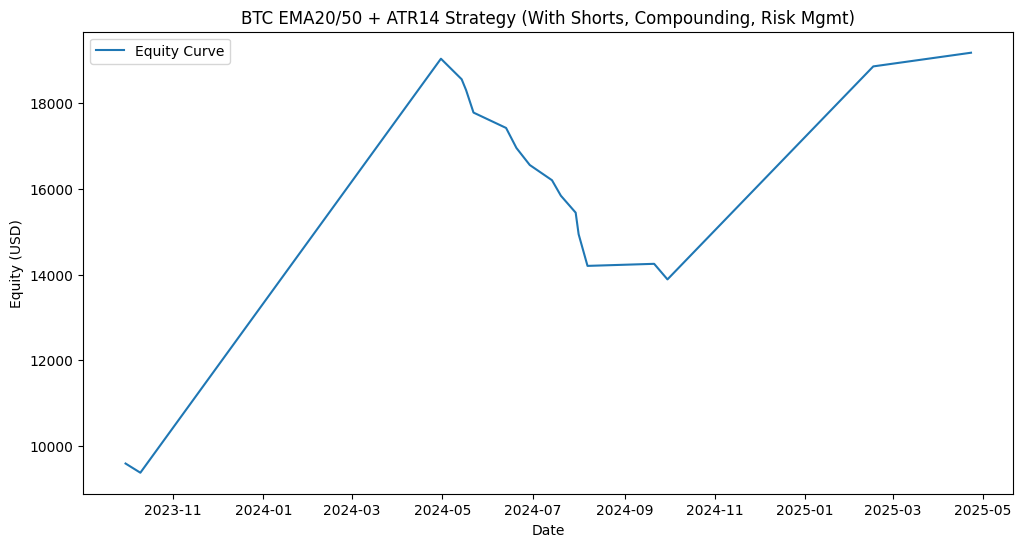

Final Equity: 19182.723975573943
Number of trades: 18

Sample trades:
                  time_open   entry_price    exit_price   side  position_size  \
0 2023-09-30 00:00:00+00:00  26754.281038  27983.750382  short       0.336235   
1 2023-10-10 00:00:00+00:00  27530.784890  26873.321121   long       0.326988   
2 2024-04-30 00:00:00+00:00  26862.375446  58254.009853   long       0.308081   
3 2024-05-14 00:00:00+00:00  62889.836744  66267.491467  short       0.142161   
4 2024-05-17 00:00:00+00:00  65231.580313  66940.804410  short       0.148633   
5 2024-05-22 00:00:00+00:00  71448.195191  67929.563039   long       0.148957   
6 2024-06-13 00:00:00+00:00  68526.097774  66011.093727   long       0.142722   
7 2024-06-20 00:00:00+00:00  66490.294175  64096.198188   long       0.195728   
8 2024-06-29 00:00:00+00:00  60277.414656  62678.292079  short       0.165390   
9 2024-07-14 00:00:00+00:00  62851.980068  64870.152815  short       0.175955   

           pnl        equity  cumulati

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load BTC dataset ---
btc = pd.read_csv("BTC_2years.csv", parse_dates=["time_open"])
btc = btc.sort_values("time_open").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
initial_equity = 10000
risk_per_trade = 0.02  # risk 2% of equity per trade

# --- Indicators ---
btc["EMA20"] = btc["time_close_price"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["time_close_price"].ewm(span=ema_long, adjust=False).mean()

# ATR14 calculation
btc["high_low"] = btc["time_high"] - btc["time_low"]
btc["high_close"] = np.abs(btc["time_high"] - btc["time_close_price"].shift())
btc["low_close"] = np.abs(btc["time_low"] - btc["time_close_price"].shift())
btc["TR"] = btc[["high_low", "high_close", "low_close"]].max(axis=1)
btc["ATR14"] = btc["TR"].rolling(atr_period).mean()

# --- Volume filter ---
btc["vol_ma20"] = btc["volume"].rolling(20).mean()

# --- Trading logic ---
trades = []
equity = initial_equity
in_position = False
position_side = None
entry_price = 0.0
stop_loss = 0.0
position_size = 0.0

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Only trade if ATR is valid
    if np.isnan(row["ATR14"]):
        continue

    # --- ENTRY CONDITIONS ---
    if not in_position:
        # Long entry
        if row["EMA20"] > row["EMA50"] and row["volume"] > row["vol_ma20"]:
            risk_amount = equity * risk_per_trade
            position_size = risk_amount / row["ATR14"]  # units (BTC)
            entry_price = row["time_close_price"]
            stop_loss = entry_price - row["ATR14"]
            position_side = "long"
            in_position = True

        # Short entry
        elif row["EMA20"] < row["EMA50"] and row["volume"] > row["vol_ma20"]:
            risk_amount = equity * risk_per_trade
            position_size = risk_amount / row["ATR14"]  # units (BTC)
            entry_price = row["time_close_price"]
            stop_loss = entry_price + row["ATR14"]
            position_side = "short"
            in_position = True

    # --- EXIT CONDITIONS ---
    elif in_position:
        exit_trade = False

        # Exit long
        if position_side == "long":
            if row["EMA20"] < row["EMA50"] or row["time_close_price"] <= stop_loss:
                exit_trade = True

        # Exit short
        elif position_side == "short":
            if row["EMA20"] > row["EMA50"] or row["time_close_price"] >= stop_loss:
                exit_trade = True

        if exit_trade:
            exit_price = row["time_close_price"]

            # PnL (in USD)
            if position_side == "long":
                pnl = (exit_price - entry_price) * position_size
            else:  # short
                pnl = (entry_price - exit_price) * position_size

            equity += pnl
            trades.append({
                "time_open": btc.iloc[i-1]["time_open"],
                "entry_price": entry_price,
                "exit_price": exit_price,
                "side": position_side,
                "position_size": position_size,
                "pnl": pnl,
                "equity": equity
            })

            in_position = False
            position_side = None

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["time_open"], trades_df["equity"], label="Equity Curve")
plt.title("BTC EMA20/50 + ATR14 Strategy (With Shorts, Compounding, Risk Mgmt)")
plt.xlabel("Date")
plt.ylabel("Equity (USD)")
plt.legend()
plt.show()

# --- Output ---
print("Final Equity:", equity)
print("Number of trades:", len(trades_df))
print("\nSample trades:")
print(trades_df.head(10))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ETH dataset ---
btc = pd.read_csv("ETH.csv", parse_dates=["day"])
btc = btc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["close_usd"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# --- ATR14 calculation (approx using close prices only) ---
btc["close_diff"] = btc["close_usd"].diff().abs()
btc["ATR14"] = btc["close_diff"].rolling(atr_period).mean()

# --- Trading logic (long & short) ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Entry condition
    if not in_position:
        if row["EMA20"] > row["EMA50"]:
            in_position = True
            position_type = "long"
            entry_price = row["close_usd"]
            stop_loss = entry_price - row["ATR14"]
        elif row["EMA20"] < row["EMA50"]:
            in_position = True
            position_type = "short"
            entry_price = row["close_usd"]
            stop_loss = entry_price + row["ATR14"]

    # Exit condition
    elif in_position:
        if position_type == "long":
            if row["EMA20"] < row["EMA50"] or row["close_usd"] <= stop_loss:
                exit_price = row["close_usd"]
                pnl = (exit_price - entry_price) / entry_price * notional
                trades.append({
                    "day": btc.iloc[i-1]["day"],
                    "year": btc.iloc[i-1]["day"].year,
                    "position": "long",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl
                })
                in_position = False
        elif position_type == "short":
            if row["EMA20"] > row["EMA50"] or row["close_usd"] >= stop_loss:
                exit_price = row["close_usd"]
                pnl = (entry_price - exit_price) / entry_price * notional
                trades.append({
                    "day": btc.iloc[i-1]["day"],
                    "year": btc.iloc[i-1]["day"].year,
                    "position": "short",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl
                })
                in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Yearly Strategy PnL ---
yearly_strategy = trades_df.groupby("year")["pnl"].sum()

# --- Yearly Buy-and-Hold PnL ---
btc["year"] = btc["day"].dt.year
yearly_bh = {}

for year in sorted(btc["year"].unique()):
    year_data = btc[btc["year"] == year]
    if not year_data.empty:
        start_price = year_data["close_usd"].iloc[0]
        end_price = year_data["close_usd"].iloc[-1]
        bh_pnl = (end_price - start_price) / start_price * notional
        yearly_bh[year] = bh_pnl

yearly_bh = pd.Series(yearly_bh)

# --- Combine into Comparison Table ---
comparison = pd.DataFrame({
    "Strategy PnL": yearly_strategy,
    "Buy&Hold PnL": yearly_bh
}).fillna(0)

# --- Plot cumulative PnL ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["day"], trades_df["cumulative_pnl"], label="EMA20/50 Strategy")
plt.title("ETH EMA20/50 Backtest: Strategy vs Buy&Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("\nYearly PnL Comparison:")
print(comparison)

print("\nTotal Strategy PnL:", trades_df["pnl"].sum())
print("Total Buy&Hold PnL:", yearly_bh.sum())



Yearly PnL Comparison:
       Strategy PnL   Buy&Hold PnL
2015   -2414.258067   -2288.781102
2016   78384.817913   74623.489641
2017  144119.577273  882047.524903
2018   15486.930844   -8212.222085
2019   11237.127432    -363.844606
2020    3378.332637   46481.313792
2021   66466.829464   40759.639949
2022     450.482573   -6787.092999
2023     913.421706    9192.432048
2024    4020.083366    4588.331368
2025    2852.324181    2934.094607

Total Strategy PnL: 324895.6693208225
Total Buy&Hold PnL: 1042974.8855167144


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load BTC dataset ---
btc = pd.read_csv("ETH.csv", parse_dates=["day"])
btc = btc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["close_usd"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# --- ATR14 calculation (approx using close prices only) ---
btc["close_diff"] = btc["close_usd"].diff().abs()
btc["ATR14"] = btc["close_diff"].rolling(atr_period).mean()

# --- Trading logic (long & short) ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Entry condition
    if not in_position:
        if row["EMA20"] > row["EMA50"]:
            in_position = True
            position_type = "long"
            entry_price = row["close_usd"]
            stop_loss = entry_price - row["ATR14"]
        elif row["EMA20"] < row["EMA50"]:
            in_position = True
            position_type = "short"
            entry_price = row["close_usd"]
            stop_loss = entry_price + row["ATR14"]

    # Exit condition
    elif in_position:
        if position_type == "long":
            if row["EMA20"] < row["EMA50"] or row["close_usd"] <= stop_loss:
                exit_price = row["close_usd"]
                pnl = (exit_price - entry_price) / entry_price * notional
                trades.append({
                    "day": btc.iloc[i-1]["day"],
                    "position": "long",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl
                })
                in_position = False
        elif position_type == "short":
            if row["EMA20"] > row["EMA50"] or row["close_usd"] >= stop_loss:
                exit_price = row["close_usd"]
                pnl = (entry_price - exit_price) / entry_price * notional
                trades.append({
                    "day": btc.iloc[i-1]["day"],
                    "position": "short",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl
                })
                in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Metrics ---
total_trades = len(trades_df)
long_trades = trades_df[trades_df["position"]=="long"]
short_trades = trades_df[trades_df["position"]=="short"]

metrics = {
    "Total PnL": trades_df["pnl"].sum(),
    "Long PnL": long_trades["pnl"].sum(),
    "Short PnL": short_trades["pnl"].sum(),
    "Number of trades": total_trades,
    "Long trades": len(long_trades),
    "Short trades": len(short_trades),
    "Win % overall": (trades_df["pnl"] > 0).mean() * 100,
    "Win % long": (long_trades["pnl"] > 0).mean() * 100 if len(long_trades) > 0 else np.nan,
    "Win % short": (short_trades["pnl"] > 0).mean() * 100 if len(short_trades) > 0 else np.nan,
    "Avg PnL per trade": trades_df["pnl"].mean(),
    "Max drawdown": trades_df["cumulative_pnl"].cummax().subtract(trades_df["cumulative_pnl"]).max()
}

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["day"], trades_df["cumulative_pnl"], label="EMA20/50 Strategy")
plt.title("BTC Momentum/Trend-Follow Strategy Backtest")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("\nBacktest Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

print("\nSample trades:")
print(trades_df.head(10))
# --- Buy-and-hold comparison ---
initial_capital = notional  # Start with same as one trade
start_price = btc["close_usd"].iloc[0]
end_price = btc["close_usd"].iloc[-1]

# Number of BTC you could buy with initial_capital
btc_amount = initial_capital / start_price

# Final value of buy-and-hold
buy_and_hold_value = btc_amount * end_price
buy_and_hold_pnl = buy_and_hold_value - initial_capital

print(f"\nBuy-and-Hold PnL over same period: ${buy_and_hold_pnl:.2f}")
print(f"Strategy Final PnL: ${metrics['Total PnL']:.2f}")




Backtest Metrics:
Total PnL: 324895.67
Long PnL: 325522.18
Short PnL: -626.51
Number of trades: 128.00
Long trades: 65.00
Short trades: 63.00
Win % overall: 26.56
Win % long: 26.15
Win % short: 26.98
Avg PnL per trade: 2538.25
Max drawdown: 7973.25

Sample trades:
         day position  entry_price  exit_price           pnl  cumulative_pnl
0 2015-11-02    short     1.190417    0.994896   1642.457123     1642.457123
1 2015-11-10     long     0.928403    0.849028   -854.962974      787.494149
2 2015-12-07     long     0.850938    0.793704   -672.592321      114.901828
3 2015-12-09    short     0.791101    0.815822   -312.488772     -197.586944
4 2015-12-11    short     0.853099    0.965786  -1320.916482    -1518.503425
5 2015-12-17     long     0.967512    0.922894   -461.159809    -1979.663234
6 2015-12-22     long     0.907241    0.867813   -434.594833    -2414.258067
7 2016-04-21     long     0.865199    8.007847  82554.992186    80140.734118
8 2016-04-30    short     8.017257    8.7

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ETH dataset ---
btc = pd.read_csv("New_Query (1).csv", parse_dates=["day"])
btc = btc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["close_usd"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# --- ATR14 calculation (approx using close prices only) ---
btc["close_diff"] = btc["close_usd"].diff().abs()
btc["ATR14"] = btc["close_diff"].rolling(atr_period).mean()

# --- Trading logic (long only) ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0
entry_date = None

for i in range(1, len(btc)):
    row = btc.iloc[i]

    # Entry condition - only long positions
    if not in_position:
        if row["EMA20"] > row["EMA50"]:
            in_position = True
            entry_price = row["close_usd"]
            entry_date = row["day"]
            stop_loss = entry_price - row["ATR14"]

    # Exit condition
    elif in_position:
        if row["EMA20"] < row["EMA50"] or row["close_usd"] <= stop_loss:
            exit_price = row["close_usd"]
            exit_date = row["day"]
            pnl = (exit_price - entry_price) / entry_price * notional
            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "year": exit_date.year,
                "position": "long",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": pnl,
                "outcome": "win" if pnl > 0 else "loss"
            })
            in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Yearly Strategy PnL ---
yearly_strategy = trades_df.groupby("year")["pnl"].sum()

# --- Yearly Buy-and-Hold PnL ---
btc["year"] = btc["day"].dt.year
yearly_bh = {}

for year in sorted(btc["year"].unique()):
    year_data = btc[btc["year"] == year]
    if not year_data.empty:
        start_price = year_data["close_usd"].iloc[0]
        end_price = year_data["close_usd"].iloc[-1]
        bh_pnl = (end_price - start_price) / start_price * notional
        yearly_bh[year] = bh_pnl

yearly_bh = pd.Series(yearly_bh)

# --- Combine into Comparison Table ---
comparison = pd.DataFrame({
    "Strategy PnL": yearly_strategy,
    "Buy&Hold PnL": yearly_bh
}).fillna(0)

# --- Plot cumulative PnL ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["exit_date"], trades_df["cumulative_pnl"], label="EMA20/50 Long-Only Strategy")
plt.title("ETH EMA20/50 Long-Only Backtest: Strategy vs Buy&Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("\nAll Trades:")
print(trades_df[["entry_date","exit_date","year","position","entry_price","exit_price","pnl","outcome"]])

print("\nYearly PnL Comparison:")
print(comparison)

print("\nTotal Strategy PnL:", trades_df["pnl"].sum())
print("Total Buy&Hold PnL:", yearly_bh.sum())


All Trades:
   entry_date  exit_date  year position  entry_price  exit_price  \
0  2015-09-09 2015-09-11  2015     long       243.41      238.33   
1  2015-10-07 2015-10-08  2015     long       246.17      243.07   
2  2015-10-09 2016-01-26  2016     long       242.50      392.00   
3  2016-02-20 2016-03-05  2016     long       421.60      410.78   
4  2016-03-06 2016-08-05  2016     long       400.52      578.28   
5  2016-09-13 2016-09-22  2016     long       608.02      597.28   
6  2016-09-23 2017-03-27  2017     long       596.20      972.05   
7  2017-04-05 2017-07-19  2017     long      1134.14     2323.08   
8  2017-07-21 2017-07-22  2017     long      2838.41     2668.63   
9  2017-07-23 2017-07-26  2017     long      2808.10     2577.77   
10 2017-07-27 2018-01-22  2018     long      2538.71    11633.10   
11 2018-04-29 2018-05-12  2018     long      9346.41     8441.44   
12 2018-05-13 2018-05-18  2018     long      8515.49     8091.83   
13 2018-07-25 2018-07-26  2018     

In [ ]:
import numpy as np

def max_drawdown(cumulative):
    """Calculate max drawdown from cumulative pnl series."""
    roll_max = cumulative.cummax()
    drawdown = cumulative - roll_max
    return drawdown.min()

def calculate_metrics(subset, notional):
    """Helper to calculate metrics for a subset of trades."""
    if subset.empty:
        return {
            "count": 0, "win_rate": 0, "avg_win": 0, "avg_loss": 0,
            "profit_factor": 0, "expectancy": 0, "total_pnl": 0, "sharpe": 0,
        }

    count = len(subset)
    wins = (subset["pnl"] > 0).sum()
    losses = (subset["pnl"] <= 0).sum()
    win_rate = wins / count if count > 0 else 0

    avg_win = subset.loc[subset["pnl"] > 0, "pnl"].mean()
    avg_loss = subset.loc[subset["pnl"] <= 0, "pnl"].mean()
    profit_factor = (
        subset.loc[subset["pnl"] > 0, "pnl"].sum() /
        abs(subset.loc[subset["pnl"] <= 0, "pnl"].sum())
        if losses > 0 else np.inf
    )

    expectancy = subset["pnl"].mean()
    total_pnl = subset["pnl"].sum()

    # Sharpe
    trade_returns = subset["pnl"] / notional
    sharpe = (
        (trade_returns.mean() / trade_returns.std()) *
        np.sqrt(252 / trade_returns.count())
        if trade_returns.std() != 0 else 0
    )

    return {
        "count": count,
        "win_rate": win_rate,
        "avg_win": avg_win,
        "avg_loss": avg_loss,
        "profit_factor": profit_factor,
        "expectancy": expectancy,
        "total_pnl": total_pnl,
        "sharpe": sharpe,
    }

if not trades_df.empty:
    # Overall metrics
    total_trades = len(trades_df)
    wins = (trades_df["pnl"] > 0).sum()
    losses = (trades_df["pnl"] <= 0).sum()
    win_rate = wins / total_trades if total_trades > 0 else 0

    avg_win = trades_df.loc[trades_df["pnl"] > 0, "pnl"].mean()
    avg_loss = trades_df.loc[trades_df["pnl"] <= 0, "pnl"].mean()
    profit_factor = (
        trades_df.loc[trades_df["pnl"] > 0, "pnl"].sum() /
        abs(trades_df.loc[trades_df["pnl"] <= 0, "pnl"].sum())
        if losses > 0 else np.inf
    )

    expectancy = trades_df["pnl"].mean()
    total_profit = trades_df["pnl"].sum()

    equity_curve = trades_df["pnl"].cumsum()
    trade_returns = trades_df["pnl"] / notional
    sharpe_ratio = (
        (trade_returns.mean() / trade_returns.std()) *
        np.sqrt(252 / trade_returns.count())
        if trade_returns.std() != 0 else 0
    )

    mdd = max_drawdown(equity_curve)

    total_days = (btc["day"].iloc[-1] - btc["day"].iloc[0]).days
    years = total_days / 365.25
    cagr = (
        (equity_curve.iloc[-1] / notional + 1) ** (1 / years) - 1
        if years > 0 else 0
    )

    # --- Long metrics (all trades are long now) ---
    longs = trades_df[trades_df["position"] == "long"]
    long_metrics = calculate_metrics(longs, notional)

    # --- Yearly metrics ---
    yearly_metrics = {}
    for year, year_trades in trades_df.groupby("year"):
        yearly_metrics[year] = calculate_metrics(year_trades, notional)

    # --- Print results ---
    print("\n--- Long Trades ---")
    print(f"Count: {long_metrics['count']}")
    print(f"Win Rate: {long_metrics['win_rate']:.2%}")
    print(f"Average Win: {long_metrics['avg_win']:.2f} USD")
    print(f"Average Loss: {long_metrics['avg_loss']:.2f} USD")
    print(f"Profit Factor: {long_metrics['profit_factor']:.2f}")
    print(f"Expectancy: {long_metrics['expectancy']:.2f} USD")
    print(f"Total PnL: {long_metrics['total_pnl']:.2f} USD")
    print(f"Sharpe Ratio: {long_metrics['sharpe']:.2f}")

    print("\n--- Overall Strategy Performance ---")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: {avg_win:.2f} USD")
    print(f"Average Loss: {avg_loss:.2f} USD")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Expectancy (avg PnL per trade): {expectancy:.2f} USD")
    print(f"Total Profit: {total_profit:.2f} USD")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {mdd:.2f} USD")
    print(f"CAGR: {cagr:.2%}")

    # --- Print yearly metrics ---
    print("\n--- Yearly PnL and Sharpe ---")
    for year, metrics in yearly_metrics.items():
        print(f"{year}: PnL = {metrics['total_pnl']:.2f} USD, Sharpe = {metrics['sharpe']:.2f}")

else:
    print("No trades were generated.")


--- Long Trades ---
Count: 51
Win Rate: 31.37%
Average Win: 8805.43 USD
Average Loss: -416.00 USD
Profit Factor: 9.68
Expectancy: 2477.00 USD
Total PnL: 126327.05 USD
Sharpe Ratio: 0.74

--- Overall Strategy Performance ---
Total Trades: 51
Win Rate: 31.37%
Average Win: 8805.43 USD
Average Loss: -416.00 USD
Profit Factor: 9.68
Expectancy (avg PnL per trade): 2477.00 USD
Total Profit: 126327.05 USD
Sharpe Ratio: 0.74
Max Drawdown: -4650.71 USD
CAGR: 29.85%

--- Yearly PnL and Sharpe ---
2015: PnL = -334.63 USD, Sharpe = -32.09
2016: PnL = 10169.90 USD, Sharpe = 6.18
2017: PnL = 15368.89 USD, Sharpe = 5.52
2018: PnL = 32267.88 USD, Sharpe = 1.57
2019: PnL = 13366.57 USD, Sharpe = 2.73
2020: PnL = 3106.46 USD, Sharpe = 7.36
2021: PnL = 35768.96 USD, Sharpe = 4.21
2022: PnL = -3235.14 USD, Sharpe = -6.55
2023: PnL = 2791.91 USD, Sharpe = 2.39
2024: PnL = 9720.37 USD, Sharpe = 1.81
2025: PnL = 7335.88 USD, Sharpe = 13.73


In [ ]:
import pandas as pd
import numpy as np

# --- Load ETH dataset ---
btc = pd.read_csv("New_Query (1).csv", parse_dates=["day"])
btc = btc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
btc["EMA20"] = btc["close_usd"].ewm(span=ema_short, adjust=False).mean()
btc["EMA50"] = btc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# --- ATR14 calculation (simplified) ---
btc["close_diff"] = btc["close_usd"].diff().abs()
btc["ATR14"] = btc["close_diff"].rolling(atr_period).mean()


def backtest(stop_mult=1.0, tp_mult=2.0):
    trades = []
    in_position = False
    entry_price = 0.0
    stop_loss = 0.0
    take_profit = 0.0
    entry_date = None

    for i in range(1, len(btc)):
        row = btc.iloc[i]

        if not in_position:
            # Only enter long positions when EMA20 > EMA50
            if row["EMA20"] > row["EMA50"]:
                in_position = True
                entry_price = row["close_usd"]
                entry_date = row["day"]
                stop_loss = entry_price - stop_mult * row["ATR14"]
                take_profit = entry_price + tp_mult * row["ATR14"]

        elif in_position:
            # Exit long position on signal reversal, stop loss, or take profit
            if (row["EMA20"] < row["EMA50"] or
                row["close_usd"] <= stop_loss or
                row["close_usd"] >= take_profit):
                exit_price = row["close_usd"]
                exit_date = row["day"]
                pnl = (exit_price - entry_price) / entry_price * notional
                trades.append({
                    "entry_date": entry_date,
                    "exit_date": exit_date,
                    "position": "long",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": pnl,
                    "outcome": "win" if pnl > 0 else "loss"
                })
                in_position = False

    return pd.DataFrame(trades)


def evaluate(trades_df):
    if trades_df.empty:
        return {"trades": 0, "win_rate": 0, "profit_factor": 0, "expectancy": 0}

    total_trades = len(trades_df)
    wins = (trades_df["pnl"] > 0).sum()
    losses = (trades_df["pnl"] <= 0).sum()
    win_rate = wins / total_trades if total_trades > 0 else 0

    avg_win = trades_df.loc[trades_df["pnl"] > 0, "pnl"].mean()
    avg_loss = trades_df.loc[trades_df["pnl"] <= 0, "pnl"].mean()
    profit_factor = (trades_df.loc[trades_df["pnl"] > 0, "pnl"].sum() /
                     abs(trades_df.loc[trades_df["pnl"] <= 0, "pnl"].sum())) if losses > 0 else np.inf
    expectancy = trades_df["pnl"].mean()

    return {
        "trades": total_trades,
        "win_rate": win_rate,
        "profit_factor": profit_factor,
        "expectancy": expectancy
    }


# --- Grid search over stop-loss & take-profit multiples ---
stop_values = [0.5, 1.0, 1.5]
tp_values = [1.0, 2.0, 3.0]

results = []

for s in stop_values:
    for t in tp_values:
        trades_df = backtest(stop_mult=s, tp_mult=t)
        metrics = evaluate(trades_df)
        results.append({
            "Stop x ATR": s,
            "TP x ATR": t,
            **metrics
        })

# --- Show results ---
results_df = pd.DataFrame(results)
print("\n--- Grid Search Results ---")
print(results_df.sort_values("win_rate", ascending=False).to_string(index=False))


--- Grid Search Results ---
 Stop x ATR  TP x ATR  trades  win_rate  profit_factor  expectancy
        1.5       1.0     581  0.638554       1.366371   76.425383
        1.0       1.0     650  0.592308       1.386789   73.520142
        1.5       2.0     435  0.567816       1.579634  143.217885
        1.0       2.0     481  0.536383       1.656185  143.434357
        1.5       3.0     336  0.520833       1.649697  186.101148
        0.5       1.0     756  0.503968       1.326890   55.067636
        1.0       3.0     374  0.481283       1.723490  183.808143
        0.5       2.0     563  0.454707       1.561543  108.794170
        0.5       3.0     439  0.410023       1.742624  152.149727


In [ ]:
# --- Performance Metrics ---
import numpy as np

def max_drawdown(cumulative):
    """Calculate max drawdown from cumulative pnl series."""
    roll_max = cumulative.cummax()
    drawdown = cumulative - roll_max
    return drawdown.min()

if not trades_df.empty:
    total_trades = len(trades_df)
    wins = (trades_df["pnl"] > 0).sum()
    losses = (trades_df["pnl"] <= 0).sum()
    win_rate = wins / total_trades if total_trades > 0 else 0

    avg_win = trades_df.loc[trades_df["pnl"] > 0, "pnl"].mean()
    avg_loss = trades_df.loc[trades_df["pnl"] <= 0, "pnl"].mean()
    profit_factor = trades_df.loc[trades_df["pnl"] > 0, "pnl"].sum() / abs(trades_df.loc[trades_df["pnl"] <= 0, "pnl"].sum()) if losses > 0 else np.inf

    expectancy = trades_df["pnl"].mean()
    total_profit = trades_df["pnl"].sum()  # Total profits

    # Cumulative PnL for drawdown calculation
    equity_curve = trades_df["pnl"].cumsum()

    # Sharpe ratio based on trade returns
    trade_returns = trades_df["pnl"] / notional  # % return per trade
    sharpe_ratio = (trade_returns.mean() / trade_returns.std()) * np.sqrt(252 / trade_returns.count()) if trade_returns.std() != 0 else 0

    mdd = max_drawdown(equity_curve)

    # CAGR
    total_days = (btc["day"].iloc[-1] - btc["day"].iloc[0]).days
    years = total_days / 365.25
    cagr = (equity_curve.iloc[-1] / notional + 1) ** (1 / years) - 1 if years > 0 else 0

    # --- Print results ---
    print("\n--- Strategy Performance Metrics ---")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: {avg_win:.2f} USD")
    print(f"Average Loss: {avg_loss:.2f} USD")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Expectancy (avg PnL per trade): {expectancy:.2f} USD")
    print(f"Total Profit: {total_profit:.2f} USD")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {mdd:.2f} USD")
    print(f"CAGR: {cagr:.2%}")
else:
    print("No trades were generated.")



--- Strategy Performance Metrics ---
Total Trades: 336
Win Rate: 52.08%
Average Win: 907.28 USD
Average Loss: -597.79 USD
Profit Factor: 1.65
Expectancy (avg PnL per trade): 186.10 USD
Total Profit: 62529.99 USD
Sharpe Ratio: 0.18
Max Drawdown: -10551.54 USD
CAGR: 21.91%
